In [17]:
import numpy as np
import scipy as sp
from pathlib import Path
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
matplotlib.rcParams.update({'font.size': 16})

import corner
from iminuit import Minuit

np.random.seed(1)

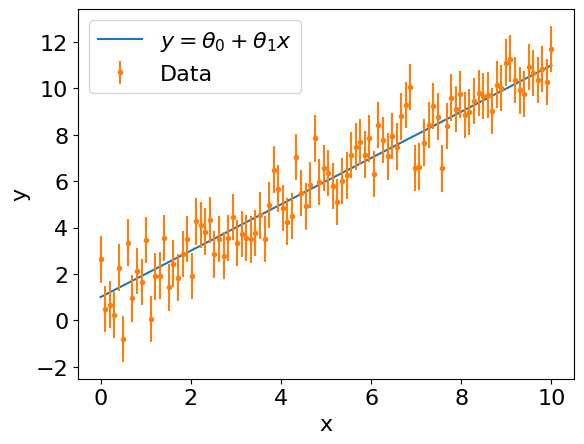

In [18]:
x = np.linspace(0,10, 100)
t0, t1 = 1,1
y = t0 + t1*x
data = y + np.random.normal(0, 1, size=len(y))

plt.plot(x,y, label = r'$y=\theta_0+\theta_1 x$')
plt.errorbar(x,data, 1, fmt='.', label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.savefig('plots/linear_data.pdf', bbox_inches='tight')

In [19]:
def nll(theta0, theta1, x, y, yerr=1):
    '''
    -2*log(p(data|theta))
    '''
    y_pred = theta0 + theta1 * x
    residuals = y - y_pred
    return np.sum((residuals / yerr)**2)

def nlprior(theta0, theta1):
    '''
    -2*log(p(theta))
    '''
    p0 = 0 if 0 <= theta0 <= 2 else np.inf
    sigma1 = 0.03
    p1 = ((theta1-t1)/sigma1)**2
    return p0+p1

def nlposterior(theta0, theta1, x, y):
    '''
    -2*log(p(theta|data))
    '''
    return nll(theta0, theta1, x, y) + nlprior(theta0, theta1)

In [20]:
Path('plots').mkdir(parents=True, exist_ok=True)

def plot_2d_pdf_contour(
        pdf_function,
        x_range=(0.3, 1.7),
        y_range=(0.9, 1.1),
        resolution=500,
        x_sigma=None,
        y_sigma=None,
        title=None,
        file=None
        ):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)

    Z = np.vectorize(lambda x, y: pdf_function(x, y))(X, Y)

    plt.contour(X, Y, Z, cmap='Purples_r', levels=[1,4,9,16])
    ind_Zmin = np.unravel_index(np.argmin(Z), Z.shape)
    plt.plot(X[ind_Zmin], Y[ind_Zmin], 'x', label=r'$(\hat\theta_0, \hat \theta_1)$')
    if x_sigma:
        plt.vlines([x_sigma[0]-x_sigma[1], x_sigma[0]+x_sigma[1]], *y_range, alpha=0.5, label=r'$\pm 1\sigma$')
        plt.xticks([x_sigma[0]+ i * x_sigma[1] for i in range(-3,4,1)])
    if y_sigma:
        plt.hlines([y_sigma[0]-y_sigma[1], y_sigma[0]+y_sigma[1]], *x_range, alpha=0.5)
        plt.yticks([y_sigma[0]+ i * y_sigma[1] for i in range(-3,4,1)])
    
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    if title:
        plt.title(title)
    plt.colorbar(label=r'$N^2\sigma$')
    plt.legend()
    if file:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

In [21]:
nll_unconstr = lambda t0, t1: nll(t0, t1, x, y)

m = Minuit(nll_unconstr, 1,1, name=(r'$\theta_0$', r'$\theta_1$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 34               │
│ EDM = 3.71e-29 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\theta_0$ │    1.0    │    0.2    │            │            │         │         │       │
│ 1 │ $\theta_1$ │   1.000   │   0.034   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬───────────────────────┐
│            │ $\theta_0$ $\theta_1$ │
├────────────┼───────────────────────┤
│ $\theta_0$ │     0.0394    -0.0059 │
│ $\theta_1$ │    -0.0059    0.00118 │
└────────────┴───────────────────────┘

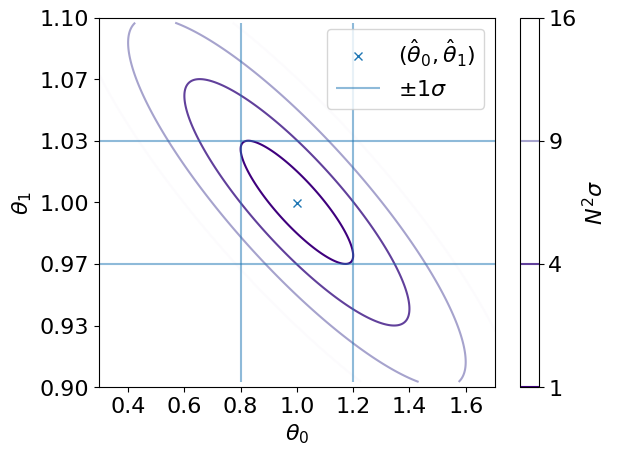

In [22]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(nll_unconstr, x_sigma=sigmax, y_sigma=sigmay, file='plots/nll_unconstr.pdf')

In [23]:
nll_constr = lambda th0, th1: nlposterior(th0, th1, x, y)

m = Minuit(nll_constr, 1,1, name=(r'$\theta_0$', r'$\theta_1$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 34               │
│ EDM = 2.92e-29 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\theta_0$ │   1.00    │   0.15    │            │            │         │         │       │
│ 1 │ $\theta_1$ │   1.000   │   0.023   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬───────────────────────┐
│            │ $\theta_0$ $\theta_1$ │
├────────────┼───────────────────────┤
│ $\theta_0$ │     0.0227    -2.5e-3 │
│ $\theta_1$ │    -2.5e-3    0.00051 │
└────────────┴───────────────────────┘

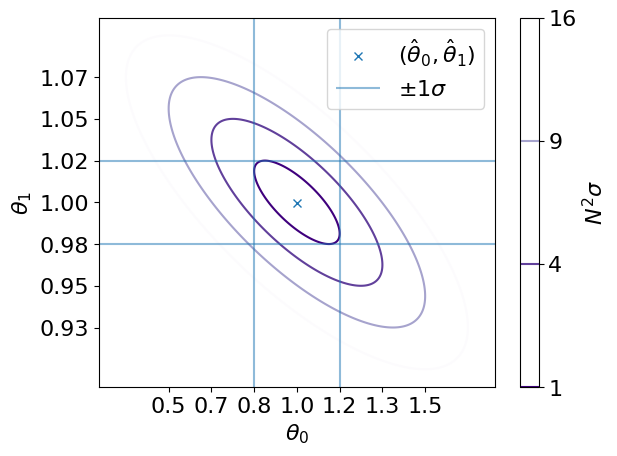

In [24]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(nll_constr, x_sigma=sigmax, y_sigma=sigmay, file='plots/nll_constr.pdf')

In [25]:
def metropolis_hastings(nlposterior, iterations, initial, proposal_std):
    samples = [initial]
    current = initial
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)
        
        # Compute acceptance ratio
        nlog_current = nlposterior(current)
        nlog_proposal = nlposterior(proposal)
        nlog_alpha = max(0, nlog_proposal - nlog_current)
        
        # Accept/reject step
        if -2*np.log(np.random.rand()) > nlog_alpha:
            current = proposal  # Accept proposal
        
        samples.append(current)
    
    return np.array(samples)

In [26]:
# Parameters for MCMC
iterations = 500000
initial = [1, 1]
chains=8
proposal_std = [0.1, 0.1]

nlpost = lambda pars: nlposterior(*pars, x, y)

# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 2), np.random.uniform(0, 2)] for _ in range(8)
]

def run_chain(initial_point):
    chain = metropolis_hastings(nlpost, iterations, initial_point, proposal_std)
    return chain

# Using multiprocessing to run the chains in parallel
with multiprocessing.Pool(processes=chains) as pool:
    chains = pool.map(run_chain, initial_points)

# Combine all chains
samples = np.vstack(chains)


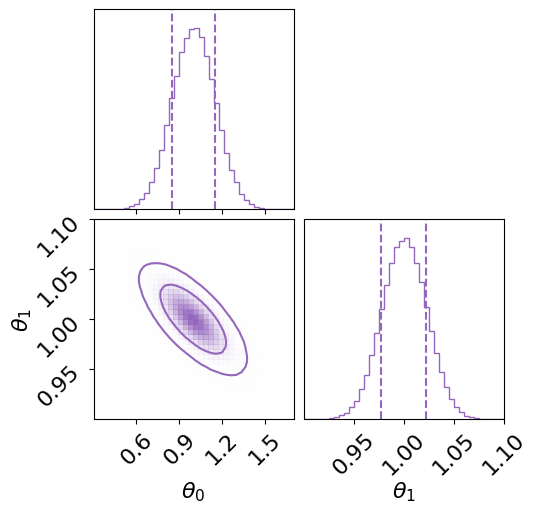

In [27]:
fig = corner.corner(
    samples,
    bins=40,
    range=[(0.3,1.7), (0.9,1.1)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\theta_0$', r'$\theta_1$'],
    color='tab:purple',
    );

file='plots/posterior.pdf'
fig.savefig(file)

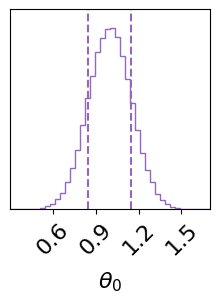

In [28]:
fig = corner.corner(
    samples[:,0],
    bins=40,
    range=[(0.3,1.7)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\theta_0$', r'$\theta_1$'],
    color='tab:purple',
    );

file='plots/marginal_posterior.pdf'
fig.savefig(file)

In [29]:
np.mean(samples[:,0]), np.std(samples[:,0])

(np.float64(0.9975766723127338), np.float64(0.15113465423784195))

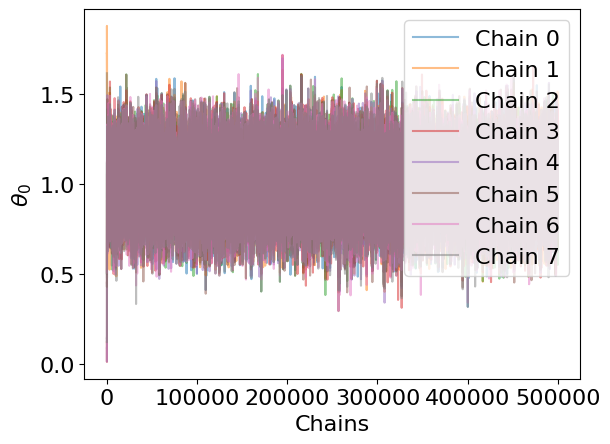

In [54]:
for i,c in enumerate(chains):
    plt.plot(c[:,0], alpha=0.5, label=f'Chain {i}')

plt.xlabel(r'Chains')
plt.ylabel(r'$\theta_0$')
plt.legend(loc='upper right')

file='plots/trace_theta0.pdf'
plt.savefig(file, bbox_inches='tight')

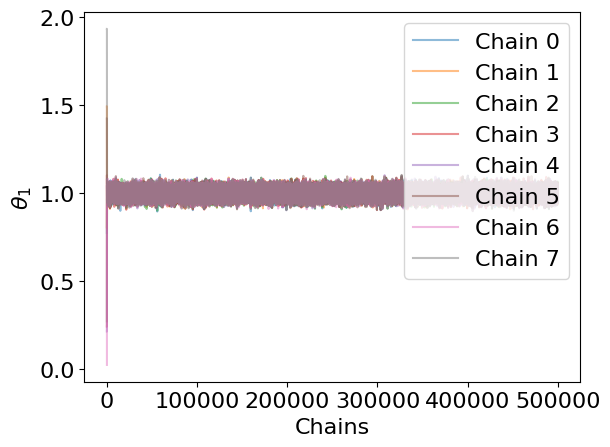

In [53]:
for i,c in enumerate(chains):
    plt.plot(c[:,1], alpha=0.5, label=f'Chain {i}')

plt.xlabel(r'Chains')
plt.ylabel(r'$\theta_1$')
plt.legend(loc='upper right')

file='plots/trace_theta1.pdf'
plt.savefig(file, bbox_inches='tight')

In [31]:
def likelihood(theta0, theta1, x, y, sigma=1):
    """Gaussian likelihood for linear model."""
    y_pred = theta0 + theta1 * x
    residuals = y - y_pred
    return np.exp(-0.5 * np.sum((residuals / sigma)**2))

def prior(theta0, theta1):
    """Flat prior (constant for all theta)."""
    p0 = 1 if 0 <= theta0 <= 2 else 0
    sigma1 = 0.03
    p1 = np.exp(-0.5 * ((theta1-t1)/sigma1)**2)
    return p0*p1

# Posterior density
def posterior(theta0, theta1, x, y):
    """Posterior density proportional to likelihood * prior."""
    return likelihood(theta0, theta1, x, y) * prior(theta0, theta1)


In [32]:
# Metropolis-Hastings Algorithm
def metropolis_hastings(iterations, initial, proposal_std, x, y):
    samples = [initial]
    current = initial

    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)

        # Compute acceptance ratio
        p_current = posterior(current[0], current[1], x, y)
        p_proposal = posterior(proposal[0], proposal[1], x, y)
        alpha = min(1, p_proposal / p_current)

        # Accept/reject step
        if np.random.rand() < alpha:
            current = proposal  # Accept proposal

        samples.append(current)

    return np.array(samples)

# Parameters for MCMC
iterations = 500000
initial = [1, 1]  # Starting values for [theta0, theta1]
proposal_std = [0.5, 0.5]  # Standard deviation of proposal distribution

# Run Metropolis-Hastings
# samples = metropolis_hastings(iterations, initial, proposal_std, x, y)